# 1. Import Libraries

In [61]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 2. Select the Top Playlist and Import Our Datasets

Đây là 10 playlists có triệu likes và hay nhất trên spotify (theo https://www.thegioididong.com/hoi-dap/nhung-playlist-trieu-likes-hay-va-dang-nghe-nhat-tren-1330612#hmenuid3) 

In [62]:
top_spotify_playlist = [
    ('4bLK0LxkbTzblG1m4od1vK', 'Chill Hits'),
    ('7mu32EJ30EOpNlYM4x4ggQ', 'Hot Acoustics'),
    ('7cwfgzb9unteXMdBq9BECX', 'The Most Beautiful Songs in the World'),
    ('3fDGyLvwvj09vlOPT2WVyv', 'Alone Again'),
    ('1kI3z6Q7NQduLPHmxBdmGQ', 'Mega Hit Mix'),
    ('0xQKFphRBuoVPBGhUUaaaW', 'All of 2010s'),
    ('7tu8NgtdBwi5BEHZi7oCDo', 'Happy Hits'),
    ('6P5YNRpDdVZizOoZwerQYO', 'Hit Rewind'),
    ('0Ue3neJqLCG54G1xYokQPj', 'Songs to Sing in the Shower'),
    ('3WTYr91qj6cqXGyqz43cPS', 'Soft Pop Hits')
]

Import Dataset

In [63]:
tracks_df = pd.read_csv('../data/processed_data.csv')
tracks_df.head()

,track_name,track_id,track_uri,artist_name,album_name,album_uri,danceability,energy,key,loudness,...,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature,popularity,release_date
0,Shape of You,7qiZfU4dY1lWllzX7mPBI3,spotify:track:7qiZfU4dY1lWllzX7mPBI3,Ed Sheeran,÷ (Deluxe),spotify:album:3T4tUhGYeRNVUGevb0wThu,0.825,0.652,1,-3.183,...,0.581,0.000000,0.0931,0.931,95.977,spotify:track:7qiZfU4dY1lWllzX7mPBI3,233712,4,86,2017-03
1,How Long,6wmAHw1szh5RCKSRjiXhPe,spotify:track:6wmAHw1szh5RCKSRjiXhPe,Charlie Puth,Voicenotes,spotify:album:0mZIUXje90JtHxPNzWsJNR,0.845,0.561,1,-5.253,...,0.211,0.000003,0.0383,0.811,109.974,spotify:track:6wmAHw1szh5RCKSRjiXhPe,200853,4,72,2018-05
2,Attention,5cF0dROlMOK5uNZtivgu50,spotify:track:5cF0dROlMOK5uNZtivgu50,Charlie Puth,Voicenotes,spotify:album:0mZIUXje90JtHxPNzWsJNR,0.775,0.613,3,-4.586,...,0.109,0.000023,0.1340,0.797,100.066,spotify:track:5cF0dROlMOK5uNZtivgu50,208786,4,79,2018-05
3,Patient,2ZrHbO88rM6Ijeg0aJmSzl,spotify:track:2ZrHbO88rM6Ijeg0aJmSzl,Charlie Puth,Voicenotes,spotify:album:0mZIUXje90JtHxPNzWsJNR,0.675,0.604,1,-6.266,...,0.752,0.000000,0.1110,0.456,168.034,spotify:track:2ZrHbO88rM6Ijeg0aJmSzl,190533,4,54,2018-05
4,seasons,5VBjyOQzqlPNgdRPMM6prF,spotify:track:5VBjyOQzqlPNgdRPMM6prF,wave to earth,summer flows 0.02,spotify:album:3NRNR4txhuRLhnQUUlqWXH,0.372,0.273,7,-10.629,...,0.782,0.046300,0.2190,0.165,60.038,spotify:track:5VBjyOQzqlPNgdRPMM6prF,255998,4,79,2020-08


# 3. Authentication Spotipy

In [64]:
CLIENT_ID = "ea1014b7e00244639c8a4e1662892df5"
CLIENT_SECRET = "6f83fc7f62b9425398f6590543d010e0"
REDIRECT_URI = "http://localhost:8888/callback"
SCOPE = "user-library-read playlist-read-private"

# Xác thực với Spotify
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    redirect_uri=REDIRECT_URI,
    scope=SCOPE
))

# 4. Recommender

Function lấy uri của những bài hát có trong playlist

In [65]:
def get_track_from_playlist(playlist):
    id = []
    try:
        results = sp.playlist_items(playlist[0])
        print(f"Playlist items of {playlist[1]} fetched successfully.")
        for item in results['items']:
            track = item['track']
            id.append(track['uri'])
            # print(f"Track: {track['name']} by {track['artists'][0]['name']}")
        return id
    except spotipy.exceptions.SpotifyException as e:
        return 0
    except Exception as ex:
        return 0

Recommender

<Axes: >

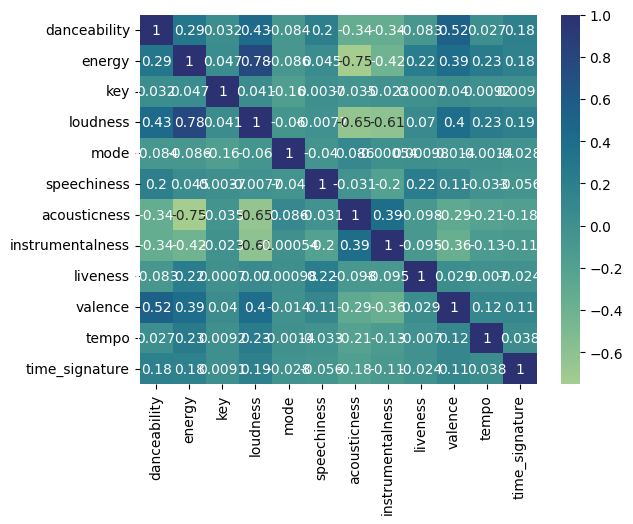

In [66]:
features = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'time_signature']

sns.heatmap(tracks_df[features].corr(), annot=True, cmap='crest')

Nhìn chung ngoài *acousticness* cùng với *energy* và *loudness* tương quan nghịch tương đối mạnh với nhau thì còn lại đều tương quan rất nhẹ. Nên ta sẽ chọn tất cả. Vì tương quan mạnh chỉ -0.75 là cao nhất. Vẫn chấp nhận được

In [67]:
def recommend_songs(df, playlist_uri, k=10, artist_limit_ratio = 0.1):
    # Chọn features là những tất cả các track features
    features = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'time_signature']
    
    # Trích ra data những tracks nằm trong playlist_uri
    playvec = df[df['track_uri'].isin(playlist_uri)]


    # print('Độ dài của playlist: ', len(playlist_uri))
    # print('Độ dài của data mà track tồn tại trong dataset: ', len(playvec))
    
    # Check if không có bài nào trong playlist_uri tồn tại trong our dataset
    if playvec.empty:
        return -1
    
    # Lọc ra những bài đã có trong 
    df = df[~df['track_name'].isin(playvec['track_name'])].copy()
    
    # Scaling data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[features])
    playvec_scaled = scaler.transform(playvec[features])

    # Tính cosine similarity matrix, từ đó lấy trung bình theo từng bài hát trong dataset.
    # Ví dụ: Song A: 0.98 (có nghĩa là Song A có mean cosine similarity với playlist cho vào là 0.98)

    similarity_matrix = cosine_similarity(df_scaled, playvec_scaled)
    df['cosine_similarity'] = similarity_matrix.mean(axis=1)

    # Sắp xếp giảm dần theo cosine_similarity
    df = df.sort_values(by='cosine_similarity', ascending=False)

    # Để tăng tính đa dạng cho recommend playlist thì với mỗi nghệ sĩ chỉ lấy tối đa artist_limit_ratio của topK
    artist_limit = max(1, int(artist_limit_ratio * k))
    recommended_songs = df.groupby('artist_name').head(artist_limit)

    # Lấy top K bài hát để ra được kết quả cuối cùng
    final_recommendations = recommended_songs.head(k)

    return final_recommendations[['track_name', 'artist_name', 'track_uri', 'cosine_similarity']]

# 5. Evaluation

## 5.1. Precision@K, Recall@K, F1-Score@K

In [68]:
def calculate_metrics_at_k(predictions, actual, k=10):
    # Chuyển sang set để tính intersection
    pred_set = set(predictions)
    actual_set = set(actual)
    
    # Tính số lượng items correctly recommended
    num_correct = len(pred_set.intersection(actual_set))
    
    # Tính Precision@K
    precision = num_correct / k if k > 0 else 0
    
    # Tính Recall@K
    recall = num_correct / len(actual_set) if len(actual_set) > 0 else 0
    
    # Tính F1-score@K
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

In [69]:
def metrics_for_playlist(tracks_df, playlist, k=50):
    # Lấy tracks từ playlist
    tracks_uri_from_playlist = get_track_from_playlist(playlist)

    # Split playlist to train_items & test_items
    train_items, test_items = train_test_split(tracks_uri_from_playlist, test_size=0.4, random_state=42)

    # Lấy recommendations từ train_items
    recommendations = recommend_songs(tracks_df, train_items, k)
    recommended_uris = recommendations['track_uri'].tolist()
    
    # Tính precision@k, recall@k, f1@k
    precision, recall, f1 = calculate_metrics_at_k(recommended_uris, test_items, k)
    
    return precision, recall, f1

In [70]:
def evaluation_top_n(playlist_list, k=50):
    precisions, recalls, f1s = [], [], []
    # Tính precision, recall, f1 cho từng playlist
    for playlist in playlist_list:
        precision, recall, f1 = metrics_for_playlist(tracks_df, playlist, k=k)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    
    return {
        f'avg_precision@{k}': np.mean(precisions),
        f'avg_recall@{k}': np.mean(recalls),
        f'avg_f1-score@{k}': np.mean(f1s)
    }

In [71]:
evaluation_top_n(top_spotify_playlist, k=50)

Playlist items of Chill Hits fetched successfully.
Playlist items of Hot Acoustics fetched successfully.
Playlist items of The Most Beautiful Songs in the World fetched successfully.
Playlist items of Alone Again fetched successfully.
Playlist items of Mega Hit Mix fetched successfully.
Playlist items of All of 2010s fetched successfully.
Playlist items of Happy Hits fetched successfully.
Playlist items of Hit Rewind fetched successfully.
Playlist items of Songs to Sing in the Shower fetched successfully.
Playlist items of Soft Pop Hits fetched successfully.


{'avg_precision@50': np.float64(0.002),
 'avg_recall@50': np.float64(0.0025),
 'avg_f1-score@50': np.float64(0.0022222222222222222)}

Có thể thấy kết quả khi evaluation theo phương pháp này khá thấp, lý do là vì:
- Chưa kết hợp nhiều phương pháp gợi ý, vì sự phức tạp của dataset
- Data chưa thực sự chất lượng, như đã thấy ở phần EDA. Cần cải thiện thêm dataset để đưa ra được các bài hát chất lượng hơn.

In [72]:
def calculate_hit_rate(playlist_list, tracks_df, k=100):
    hits = 0  # Số playlist có ít nhất một bài hát liên quan được gợi ý
    total_playlists = len(playlist_list)
    
    for playlist in playlist_list:
        # Lấy các bài hát từ playlist
        tracks_uri_from_playlist = get_track_from_playlist(playlist)
        
        # Chia playlist thành train_items và test_items
        train_items, test_items = train_test_split(tracks_uri_from_playlist, test_size=0.4, random_state=42)
        
        # Lấy các bài hát được gợi ý
        recommendations = recommend_songs(tracks_df, train_items, k)
        recommended_uris = recommendations['track_uri'].tolist()
        
        # Kiểm tra nếu có ít nhất một bài hát test_items nằm trong recommended_uris
        if any(uri in test_items for uri in recommended_uris):
            hits += 1
    
    # Tính hit rate
    hit_rate = hits / total_playlists
    return hit_rate

print('Hit rate: ', calculate_hit_rate(top_spotify_playlist, tracks_df))

Playlist items of Chill Hits fetched successfully.
Playlist items of Hot Acoustics fetched successfully.
Playlist items of The Most Beautiful Songs in the World fetched successfully.
Playlist items of Alone Again fetched successfully.
Playlist items of Mega Hit Mix fetched successfully.
Playlist items of All of 2010s fetched successfully.
Playlist items of Happy Hits fetched successfully.
Playlist items of Hit Rewind fetched successfully.
Playlist items of Songs to Sing in the Shower fetched successfully.
Playlist items of Soft Pop Hits fetched successfully.
Hit rate:  0.1


Có thể phương pháp gợi ý từ các đặc trưng nội suy của bài hát cần được đánh giá thêm với các phương pháp Online như:
- User Rating
- A/B Testing
- ...